# Controlling the multi channel temperature data logger 'Yokogawa GP10' by web interface

In [1]:
# import necessary libraries
import urllib as http
import pandas as pd
import time
import os

In [2]:
ip_of_gp10 = '192.168.10.207'

## Get device information

> @TODOs:
> - grobe Beschreibung des Messgerätes
> - Foto Messgerät + Screenshots WebUI
> - Übersetzung

Das Messgerät verfügt über ein Java-basiertes WebUI. Sämtliche Kommunikation vom oder zum Messgerät wird über HTTP GET requests übertragen.
Da die Kommunikation unverschlüsselt ist, kann sie sehr leicht mit einem Paket-Sniffer wie z.B. "Wireshark" mitgeschnitten werden.
Als Filter-Einstellung ist z.B. `ip.addr == 192.168.10.207 && http.request.method == GET` sinnvoll.

Auf die Art und Weise wurden sämtliche der im Notebook verwendeten Befehle für das Konfigurieren des Messgerätes, das Steuern der Messungen (Start/Stop Recording) sowie Auslesen der Messwertdateien reverse engineered.

> @TODOs:
> - Auslesen wichtiger Geräte-Infos, wozu:
>     - für Identifikation
>     - falls sich nach dem Firmware-Update die HTTP GET URIs und die Rückgabestrings geändert haben, könnte mit diesen Infos eine unterschiedliche Command-API realisiert werden (abhängig vom Firmware- bzw. WebUI-Stand)
    - Update 2023-04-03: auch nach dem Firmware-Update funktionieren die bisherigen HTTP GET URIs => die Realisierung einer unterschiedlichen Command-API abhängig vom FW-Stand ist daher nicht notwendig :)

Get device information (vor dem Update auf FW R5.xx.xx):

```
http://192.168.10.207/gene.cgi?msg=_INF

EA
'GX10/GP10',S5S503742,00-00-64-9f-b0-42,R3.02.02
EN
```

```
http://192.168.10.207/gene.cgi?msg=_VER

EA
B8741ZA,R3.02.02,'Main Program'
B8740ZY,R3.02.01,'Web Program'
EN
```

```
http://192.168.10.207/gene.cgi?msg=_UNR

EA
Main,0,'GP10-1E',S5S503742,00-00-64-9f-b0-42,R3.02.02,/UH /E1 /UC20,0,3,
EN
```

In [3]:
# function to retrieve device information
def get_device_info(b_verbose=False):
    dict_device_infos = {}
    
    str_uri = "http://" + ip_of_gp10 + "/gene.cgi?msg=_INF"
    str_response_inf = http.request.urlopen(str_uri).read().decode('utf-8')
    str_response_inf = str_response_inf.rstrip('\r\n') # cut trailing '\r\n'
    
    if ( str_response_inf.startswith('EA') and str_response_inf.endswith('EN') ):
        if b_verbose: print("Retrieving device infos was successful:\n{}".format(str_response_inf))
        
        str_row_list = str_response_inf.split('\r\n')
        str_row_list.remove('EA')
        str_row_list.remove('EN')
        
        if ( len(str_row_list) == 1 ):
            str_info_list = str_row_list[0].split(',')

            dict_device_infos["Device family"] = str_info_list[0].strip("'")
            dict_device_infos["Serial number"] = str_info_list[1]
            dict_device_infos["MAC address"] = str_info_list[2]
            dict_device_infos["Version FW (inf)"] = str_info_list[3]
    else:
        if b_verbose: print("There was an error while reading device infos:\n{}".format(str_response_inf))
        return
    
    str_uri = "http://" + ip_of_gp10 + "/gene.cgi?msg=_VER"
    str_response_ver = http.request.urlopen(str_uri).read().decode('utf-8')
    str_response_ver = str_response_ver.rstrip('\r\n') # cut trailing '\r\n'
    
    if ( str_response_ver.startswith('EA') and str_response_ver.endswith('EN') ):
        if b_verbose: print("Retrieving device versions was successful:\n{}".format(str_response_ver))
        
        str_row_list = str_response_ver.split('\r\n')
        str_row_list.remove('EA')
        str_row_list.remove('EN')
        
        if ( len(str_row_list) == 2 ):
            str_version_list = str_row_list[0].split(',')
            if ( str_version_list[2].strip("'") == 'Main Program' ):
                dict_device_infos["Version FW (ver)"] = str_version_list[1]
            
            str_version_list = str_row_list[1].split(',')
            if ( str_version_list[2].strip("'") == 'Web Program' ):
                dict_device_infos["Version WebUI"] = str_version_list[1]
    else:
        if b_verbose: print("There was an error while reading device versions:\n{}".format(str_response_ver))
        return
    
    str_uri = "http://" + ip_of_gp10 + "/gene.cgi?msg=_UNR"
    str_response_unr = http.request.urlopen(str_uri).read().decode('utf-8')
    str_response_unr = str_response_unr.rstrip('\r\n') # cut trailing '\r\n'
    
    if ( str_response_unr.startswith('EA') and str_response_unr.endswith('EN') ):
        if b_verbose: print("Retrieving device versions was successful:\n{}".format(str_response_unr))
        
        str_row_list = str_response_unr.split('\r\n')
        str_row_list.remove('EA')
        str_row_list.remove('EN')
        
        if ( len(str_row_list) == 1 ):
            str_info_list = str_row_list[0].split(',')
            
            dict_device_infos["Device type"] = str_info_list[2].strip("'")
    
    else:
        if b_verbose: print("There was an error while reading device versions:\n{}".format(str_response_unr))
        return
    
    # sort the dictionary by keys and return
    return dict(sorted(dict_device_infos.items()))

Print the dictionary of stored **device information**:

In [22]:
dict_dev_info = get_device_info(b_verbose=False)

# dict_dev_info

for key, val in dict_dev_info.items():
    print("{}:    \t{}".format(key, val))

Device family:    	GX10/GP10
Device type:    	GP10-1E
MAC address:    	00-00-64-9f-b0-42
Serial number:    	S5S503742
Version FW (inf):    	R5.02.03
Version FW (ver):    	R5.02.03
Version WebUI:    	R5.02.02


## Configure measuring device for recording data to SD card

### Configure the recording channels for the measurement

In [113]:
# Helper function for building the config URI and write the configurations
def config_meas_rec_channel(str_ip, str_channel, str_name, str_color):
    str_uri = "http://" + str_ip + "/gene.cgi?msg=STagIO," + str_channel + ",'" + str_name + "','';" \
               "SColorIO," + str_channel + "," + str_color + ";" \
               "SZoneIO," + str_channel + ",0,100;" \
               "SScaleIO," + str_channel + ",1,10;" \
               "SBarIO," + str_channel + ",Lower,10;" \
               "SBandIO," + str_channel + ",Off,102,255,0,0,100;" \
               "SAlmMarkIO," + str_channel + ",On,Alarm,255,0,0,255,153,51,255,153,51,255,0,0;" \
               "SValueIO," + str_channel + ",'',''"
    
    str_response = http.request.urlopen(str_uri).read().decode('utf-8')
    str_response = str_response.replace('\r\n', '')

    if (str_response == 'E0'):
        print("Configuring the channel was successful: {}".format(str_response))
    else:
        print("Configuring the channel was NOT successful: {}".format(str_response))
    
    return str_uri, str_response

In [114]:
# Dataframe with the config values for the measuring channels
df_meas_rec_channels = pd.DataFrame(columns=['Channel', 'Track Name', 'Color RGB'],
                                    data=[['0001', 'T01_Klemme_Schliesser_E1', '255,0,0'],
                                          ['0002', 'T02_Klemme_Schliesser_E2', '0,153,51'],
                                          ['0003', 'T03_Gehaeuse_Schliesser_E1', '0,51,255'],
                                          ['0004', 'T04_Gehaeuse_Schliesser_E2', '204,102,204'],
                                          ['0005', 'T05_Schaltergehaeuse_aussen', '119,170,221'],
                                          ['0006', 'T06_Raumtemperatur_1', '255,153,51'],
                                          ['0007', 'T07_Raumtemperatur_2', '153,204,51'],
                                         ])


display(df_meas_rec_channels)

,Channel,Track Name,Color RGB
0,0001,T01_Klemme_Schliesser_E1,"255,0,0"
1,0002,T02_Klemme_Schliesser_E2,"0,153,51"
2,0003,T03_Gehaeuse_Schliesser_E1,"0,51,255"
3,0004,T04_Gehaeuse_Schliesser_E2,"204,102,204"
4,0005,T05_Schaltergehaeuse_aussen,"119,170,221"
5,0006,T06_Raumtemperatur_1,"255,153,51"
6,0007,T07_Raumtemperatur_2,"153,204,51"


In [115]:
# Iterate the config dataframe and upload the configurations
for index, row in df_meas_rec_channels.iterrows():
    print("Channel: {}, Track Name: {}, Color RGB: {}\r\n".format(row['Channel'], row['Track Name'], row['Color RGB']))
    
    str_uri, str_response = config_meas_rec_channel(ip_of_gp10, row['Channel'], row['Track Name'], row['Color RGB'])

    print("URI: {}\r\nResponse: {}\r\n".format(str_uri, str_response))

Channel: 0001, Track Name: T01_Klemme_Schliesser_E1, Color RGB: 255,0,0

Configuring the channel was successful: E0
URI: http://192.168.10.207/gene.cgi?msg=STagIO,0001,'T01_Klemme_Schliesser_E1','';SColorIO,0001,255,0,0;SZoneIO,0001,0,100;SScaleIO,0001,1,10;SBarIO,0001,Lower,10;SBandIO,0001,Off,102,255,0,0,100;SAlmMarkIO,0001,On,Alarm,255,0,0,255,153,51,255,153,51,255,0,0;SValueIO,0001,'',''
Response: E0

Channel: 0002, Track Name: T02_Klemme_Schliesser_E2, Color RGB: 0,153,51

Configuring the channel was successful: E0
URI: http://192.168.10.207/gene.cgi?msg=STagIO,0002,'T02_Klemme_Schliesser_E2','';SColorIO,0002,0,153,51;SZoneIO,0002,0,100;SScaleIO,0002,1,10;SBarIO,0002,Lower,10;SBandIO,0002,Off,102,255,0,0,100;SAlmMarkIO,0002,On,Alarm,255,0,0,255,153,51,255,153,51,255,0,0;SValueIO,0002,'',''
Response: E0

Channel: 0003, Track Name: T03_Gehaeuse_Schliesser_E1, Color RGB: 0,51,255

Configuring the channel was successful: E0
URI: http://192.168.10.207/gene.cgi?msg=STagIO,0003,'T03_Geha

### Configure the display range for the measurement tracks

In [116]:
# Helper function for building the config URI and write the configurations
def config_meas_display_ranges(str_ip, str_channel, flt_range_lower, flt_range_upper):
    str_uri = "http://" + str_ip + "/gene.cgi?msg=SRangeAI," + str_channel + ",TC,K,Off," + \
               str(flt_range_lower*10) + "," + str(flt_range_upper*10) + ",0;" \
               "SMoveAve," + str_channel + ",Off,2;" \
               "SBurnOut," + str_channel + ",Off;" \
               "SRjc," + str_channel + ",Internal"
    
    #print(str_uri)
    
    str_response = http.request.urlopen(str_uri).read().decode('utf-8')
    str_response = str_response.replace('\r\n', '')

    if (str_response == 'E0'):
        print("Configuring the channel was successful: {}".format(str_response))
    else:
        print("Configuring the channel was NOT successful: {}".format(str_response))
    
    return str_uri, str_response

In [117]:
# helper function to add new rows (a list) to existing dataframe
def dataframe_add_row(df=None, row=[]):
    if (df is None):
        return
    
    # add a row
    df.loc[-1] = row
    
    # shift the index
    df.index = df.index + 1
    
    # reset the index of dataframe and avoid the old index being added as a column
    df.reset_index(drop=True, inplace=True)

In [118]:
temp_display_ranges = [20, 27] # range for heating test at 4 A DC
# temp_display_ranges = [20, 55] # range for heating test at 6 A DC
# temp_display_ranges = [20, 85] # range for heating test at 10 A DC

temp_display_ranges

[20, 27]

In [119]:
df_meas_display_ranges = pd.DataFrame(columns=['Channel', 'range_lower [°C]', 'range_upper [°C]'])

# Iterate over the dataframe 'df_meas_display_ranges' and add ranges for each channel
for index, row in df_meas_rec_channels.iterrows():
    dataframe_add_row(df_meas_display_ranges, [row['Channel'], temp_display_ranges[0], temp_display_ranges[1]])

df_meas_display_ranges

,Channel,range_lower [°C],range_upper [°C]
0,0001,20,27
1,0002,20,27
2,0003,20,27
3,0004,20,27
4,0005,20,27
5,0006,20,27
6,0007,20,27


In [120]:
# Iterate the config dataframe and upload the configurations
for index, row in df_meas_display_ranges.iterrows():
    print("Channel: {}, Range lower limit: {}, Range upper limit: {}\r\n".format(row['Channel'], row['range_lower [°C]'], row['range_upper [°C]']))
    
    str_uri, str_response = config_meas_display_ranges(ip_of_gp10, row['Channel'], row['range_lower [°C]'], row['range_upper [°C]'])

    print("URI: {}\r\nResponse: {}\r\n".format(str_uri, str_response))

Channel: 0001, Range lower limit: 20, Range upper limit: 27

Configuring the channel was successful: E0
URI: http://192.168.10.207/gene.cgi?msg=SRangeAI,0001,TC,K,Off,200,270,0;SMoveAve,0001,Off,2;SBurnOut,0001,Off;SRjc,0001,Internal
Response: E0

Channel: 0002, Range lower limit: 20, Range upper limit: 27

Configuring the channel was successful: E0
URI: http://192.168.10.207/gene.cgi?msg=SRangeAI,0002,TC,K,Off,200,270,0;SMoveAve,0002,Off,2;SBurnOut,0002,Off;SRjc,0002,Internal
Response: E0

Channel: 0003, Range lower limit: 20, Range upper limit: 27

Configuring the channel was successful: E0
URI: http://192.168.10.207/gene.cgi?msg=SRangeAI,0003,TC,K,Off,200,270,0;SMoveAve,0003,Off,2;SBurnOut,0003,Off;SRjc,0003,Internal
Response: E0

Channel: 0004, Range lower limit: 20, Range upper limit: 27

Configuring the channel was successful: E0
URI: http://192.168.10.207/gene.cgi?msg=SRangeAI,0004,TC,K,Off,200,270,0;SMoveAve,0004,Off,2;SBurnOut,0004,Off;SRjc,0004,Internal
Response: E0

Channel:

### Activate measuring channels in correct order

In [121]:
# Helper function to iterate through the config dataframe and activate measuring channels in correct order
def activate_measuring_channels(df, str_ip):
    # http://192.168.10.207/gene.cgi?msg=SGroup,1,On,'GROUP+1','0001.0002.0003.0004.0005.0006.0007'
    str_uri = "http://" + str_ip + "/gene.cgi?msg=SGroup,1,On,'GROUP+1','"
    
    for index, row in df.iterrows():
        # print("Channel: {}\r\n".format(row['Channel']))
        str_uri = str_uri + row['Channel'] + "."

    str_uri = str_uri.rstrip('.') # cut trailing '.'
    str_uri = str_uri + "'"
    
    str_response = http.request.urlopen(str_uri).read().decode('utf-8')
    str_response = str_response.replace('\r\n', '')

    if (str_response == 'E0'):
        print("Activation of measuring channels was successful: {}".format(str_response))
    else:
        print("Activation of measuring channels was NOT successful: {}".format(str_response))
    
    return str_uri, str_response

In [122]:
str_uri, str_response = activate_measuring_channels(df_meas_display_ranges, ip_of_gp10)

print("URI: {}\r\nResponse: {}".format(str_uri, str_response))

Activation of measuring channels was successful: E0
URI: http://192.168.10.207/gene.cgi?msg=SGroup,1,On,'GROUP+1','0001.0002.0003.0004.0005.0006.0007'
Response: E0


### Set timezone and summer/winter time changeover

In [123]:
# Helper function for building the config URI and write the configurations
def set_timezone_summer_winter_time_changeover(str_ip):    
    str_uri = "http://" + str_ip + "/gene.cgi?msg=STimeZone," + "1,0;" # timezone of 'Berlin' has to set to +1 h, 0 min UTC
    str_uri = str_uri + "SDateBasic,5s,NotChange;" # do not adjust time step by step
    str_uri = str_uri + "SDst,Use,Mar,Last,Sun,3," # set summer time changeover to last sunday in march, 03:00
    str_uri = str_uri + "Oct,Last,Sun,3" # set winter time changeover to last sunday in october, 03:00
    
    # print(str_uri)
    
    str_response = http.request.urlopen(str_uri).read().decode('utf-8')
    str_response = str_response.replace('\r\n', '')

    if (str_response == 'E0'):
        print("Configuring the time settings were successful: {}".format(str_response))
    else:
        print("Configuring the time settings were NOT successful: {}".format(str_response))
    
    return str_uri, str_response

In [124]:
str_uri, str_response = set_timezone_summer_winter_time_changeover(ip_of_gp10)

print("URI: {}\r\nResponse: {}".format(str_uri, str_response))

Configuring the time settings were successful: E0
URI: http://192.168.10.207/gene.cgi?msg=STimeZone,1,0;SDateBasic,5s,NotChange;SDst,Use,Mar,Last,Sun,3,Oct,Last,Sun,3
Response: E0


### Configure SNTP client for time synchronization

In [125]:
# Helper function for building the config URI and write the configurations
def config_SNTP_client(str_ip):
    str_uri = "http://" + str_ip + "/gene.cgi?msg=SClient," + "SNTP,On;" # enable SNTP client
    str_uri = str_uri + "SSntpCnct," + "'de.pool.ntp.org',123," # set URL and port of NTP server
    str_uri = str_uri + "0,0,6h,30s,On" # configure sync interval, timeout and sync on boot
    
    # print(str_uri)
    
    str_response = http.request.urlopen(str_uri).read().decode('utf-8')
    str_response = str_response.replace('\r\n', '')

    if (str_response == 'E0'):
        print("Configuring the time settings were successful: {}".format(str_response))
    else:
        print("Configuring the time settings were NOT successful: {}".format(str_response))
    
    return str_uri, str_response

In [126]:
str_uri, str_response = config_SNTP_client(ip_of_gp10)

print("URI: {}\r\nResponse: {}".format(str_uri, str_response))

Configuring the time settings were successful: E0
URI: http://192.168.10.207/gene.cgi?msg=SClient,SNTP,On;SSntpCnct,'de.pool.ntp.org',123,0,0,6h,30s,On
Response: E0


## Start and stop the recordings


In [127]:
# Helper function for starting and stopping the recording
def start_stop_recording(str_ip, start_stop):
    str_uri = "http://" + str_ip + "/gene.cgi?msg=ORec," + start_stop
    
    str_response = http.request.urlopen(str_uri).read().decode('utf-8')
    str_response = str_response.replace('\r\n', '')

    if ((str_response == 'E0') and (start_stop == "0")):
        print("Starting of the recording was successful: {}".format(str_response))
    elif ((str_response == 'E0') and (start_stop == "1")):
        print("Stopping of the recording was successful: {}".format(str_response))
    else:
        print("There was an error: {}".format(str_response))
    
    return str_uri, str_response

### Set the file type of recorded file to 'Text'

With this setting, ASCII text files are written to the SD card. These can be read in as CSV files in common spreadsheet programs. A tabulator is used as column separator.

**Attention:** This file format is NOT readable in the tool *Universal Viewer*! Therefore, for other colleagues, the format must be changed back to "Binary" at the end of the measurement!

In [111]:
# URI for setting the file type
file_type = "Text"
str_uri = "http://" + ip_of_gp10 + "/gene.cgi?msg=SDirectory,'DATA0';SFileHead,'';SFileName,Date,'';SMediaSave,On,Off;SFileFormat," + file_type

str_uri

"http://192.168.10.207/gene.cgi?msg=SDirectory,'DATA0';SFileHead,'';SFileName,Date,'';SMediaSave,On,Off;SFileFormat,Text"

In [112]:
# Set the file type by http GET request
str_response = http.request.urlopen(str_uri).read().decode('utf-8')
str_response = str_response.replace('\r\n', '')

if (str_response == 'E0'):
    print("Setting file type was successful: {}".format(str_response))
else:
    print("There was an error while setting the file type: {}".format(str_response))

Setting file type was successful: E0


### Start the recording

In [128]:
# Start (0) the recording of measurements
start_stop = "0"

str_uri, str_response = start_stop_recording(ip_of_gp10, start_stop)

print("URI: {}\r\nResponse: {}".format(str_uri, str_response))

Starting of the recording was successful: E0
URI: http://192.168.10.207/gene.cgi?msg=ORec,0
Response: E0


### Stop the recording

In [129]:
# Stop (1) the recording of measurements
start_stop = "1"

str_uri, str_response = start_stop_recording(ip_of_gp10, start_stop)

print("URI: {}\r\nResponse: {}".format(str_uri, str_response))

Stopping of the recording was successful: E0
URI: http://192.168.10.207/gene.cgi?msg=ORec,1
Response: E0


### Reset the file type of recorded file to 'Binary'

This format is the default setting of the measuring device. The resulting **GDS** files can be further processed by the Windows tool *Universal Viewer*.

The specification of the GDS file format is kept secret after inquiry with the Yokogawa support -- for "security" reasons was said there ... But this is quite nonsense, because "security by obscurity" is not a good security approach, as several incidents have impressively shown ... but anyway ...

In [141]:
# URI for setting the file type
file_type = "Binary"
str_uri = "http://" + ip_of_gp10 + "/gene.cgi?msg=SDirectory,'DATA0';SFileHead,'';SFileName,Date,'';SMediaSave,On,Off;SFileFormat," + file_type

str_uri

"http://192.168.10.207/gene.cgi?msg=SDirectory,'DATA0';SFileHead,'';SFileName,Date,'';SMediaSave,On,Off;SFileFormat,Binary"

In [142]:
# Set the file type by http GET request
str_response = http.request.urlopen(str_uri).read().decode('utf-8')
str_response = str_response.replace('\r\n', '')

if (str_response == 'E0'):
    print("Setting file type was successful: {}".format(str_response))
else:
    print("There was an error while setting the file type: {}".format(str_response))

Setting file type was successful: E0


## Read file list and download data files

### Read in the file list from SD card

In [154]:
# URI for getting the file list
str_uri = 'http://' + ip_of_gp10 + '/gene.cgi?msg=FMedia,DIR,%27/DRV0/DATA0/%27,1'

# Convert byte stream from the http response to string 
str_file_list = http.request.urlopen(str_uri).read().decode('utf-8')

# Split string by '\r\n' and convert it to a list
lst_file_list = list(str_file_list.split('\r\n'))
lst_file_list

['EA',
 '20/12/09 12:47:34      <DIR> .',
 '20/12/09 12:47:34      <DIR> ..',
 '20/12/09 12:47:34     424432 000086_201209_080310.GDS',
 '21/03/18 15:35:58      15328 000087_210318_153110.GDS',
 '21/03/18 15:45:14      12640 000088_210318_154210.GDS',
 '21/03/18 16:13:44       8984 000089_210318_161310.GDS',
 '21/03/18 16:27:08      25816 000090_210318_161510.GDS',
 '21/03/19 09:50:04     110240 000091_210319_084020.GDS',
 '21/03/25 16:59:18      19440 000092_210325_165150.GDS',
 '21/03/26 16:59:00     430832 000093_210326_121020.GDS',
 '21/03/31 18:48:44     597960 000094_210331_120550.GDS',
 '21/04/01 16:48:50     425936 000095_210401_120330.GDS',
 '21/04/06 17:15:20     277344 000096_210406_141130.GDS',
 '21/04/07 16:02:48     559048 000094_210331_120550.GDS.vdx',
 '21/04/07 16:06:02     559048 000095_210401_120330.GDS.vdx',
 '21/04/07 16:09:18     559048 000096_210406_141130.GDS.vdx',
 '21/04/08 16:52:34     460344 000097_210408_114340.GDS',
 '21/04/15 09:26:40       5850 000098_21

In [144]:
# Read file list to dataframe
df_file_list = pd.DataFrame(lst_file_list)

# Drop first 3 and last 2 rows
df_file_list.drop([0, 1, 2], inplace=True)
df_file_list.drop(df_file_list.tail(2).index, inplace=True)

# Split single column into multiple ones
df_file_list_split = df_file_list[0].str.split(expand=True)

# Reset the index of dataframe and avoid the old index being added as a column
df_file_list_split.reset_index(drop=True, inplace=True)

# display the last (i.e. newest) files
df_file_list_split.tail(8)

,0,1,2,3
76,24/08/13,12:28:28,10523,000165_240813_115850.GTD
77,24/08/13,12:42:24,1475,000166_240813_124100.GTD
78,24/08/13,13:55:04,39913,000167_240813_124600.GTD
79,24/08/13,13:56:14,1502,000168_240813_135600.GTD
80,24/08/13,16:57:54,95073,000169_240813_141000.GTD
81,24/08/14,12:00:40,96949,000170_240814_090930.GTD
82,24/08/14,12:06:18,1807,000171_240814_120540.GTD
83,24/08/14,13:50:44,56312,000172_240814_122440.GDS


In [145]:
# Rename columns by column index
df_file_list_new = df_file_list_split.rename(columns={ df_file_list_split.columns[0]: "Date", 
                                                       df_file_list_split.columns[1]: "Time",
                                                       df_file_list_split.columns[2]: "File size",
                                                       df_file_list_split.columns[3]: "File name" })

df_file_list_new.head(3)

,Date,Time,File size,File name
0,20/12/09,12:47:34,424432,000086_201209_080310.GDS
1,21/03/18,15:35:58,15328,000087_210318_153110.GDS
2,21/03/18,15:45:14,12640,000088_210318_154210.GDS


In [146]:
# Combine date and time columns to a new datetime array
# Hints:
# Parameter 'format="%y/%m/%d %H:%M:%S"' defines the INPUT data format of the raw original string
# With method '.dt.strftime('%d.%m.%Y, %H:%M:%S')' you can define the OUTPUT data format
new_dt_column = pd.to_datetime(df_file_list_new['Date'] + ' ' + df_file_list_new['Time'], format="%y/%m/%d %H:%M:%S") #.dt.strftime('%d.%m.%Y, %H:%M:%S')

# Replace values of 'Date' row with new datetime array
df_file_list_new['Date'] = new_dt_column

# Rename row to 'Datetime'
df_file_list_new = df_file_list_new.rename(columns={'Date': 'Datetime'})

# Delete unused row 'Time'
del df_file_list_new['Time']

# Cast values to correct data types
df_file_list_new['File size'] = df_file_list_new['File size'].astype(int)
df_file_list_new['File name'] = df_file_list_new['File name'].astype(str)

In [153]:
# View first 5 files in the list
df_file_list_new.tail(5)

,Datetime,File size,File name
4,2021-05-04 19:18:48,5445,000108_210504_191610.GTD
3,2021-05-04 15:26:24,3740,000107_210504_152500.GTD
2,2021-05-04 14:04:44,26320,000100_210504_134540.GTD
1,2021-05-04 13:41:48,2229,000099_210504_134140.GTD
0,2021-04-15 09:26:40,5850,000098_210415_092340.GTD


In [149]:
df_file_list_new.dtypes

Datetime     datetime64[ns]
File size             int64
File name            object
dtype: object

In [150]:
# Delete rows with file types other than GTD
# '~' negates the search string
df_file_list_new.drop(df_file_list_new[~df_file_list_new['File name'].str.contains("GTD")].index, inplace=True)

# Reset the index of dataframe and avoid the old index being added as a column
df_file_list_new.reset_index(drop=True, inplace=True)

In [151]:
# Sort the dataframe by column 'Datetime' descending to get the newest file on top
df_file_list_new.sort_values(by='Datetime', ascending=False, inplace=True)

In [152]:
#display(df_file_list_new)
df_file_list_new

,Datetime,File size,File name
33,2024-08-14 12:06:18,1807,000171_240814_120540.GTD
32,2024-08-14 12:00:40,96949,000170_240814_090930.GTD
31,2024-08-13 16:57:54,95073,000169_240813_141000.GTD
30,2024-08-13 13:56:14,1502,000168_240813_135600.GTD
29,2024-08-13 13:55:04,39913,000167_240813_124600.GTD
28,2024-08-13 12:42:24,1475,000166_240813_124100.GTD
27,2024-08-13 12:28:28,10523,000165_240813_115850.GTD
26,2023-04-03 11:40:18,2760,000155_230403_113840.GTD
25,2023-03-29 12:23:54,142982,000153_230329_091210.GTD
24,2023-03-28 17:00:14,92049,000152_230328_145730.GTD


### Download GTD files to local file system

In [67]:
# str_file_idx = "000137" # 6 A ZSR2B2
# str_file_idx = "000138" # 4 A ZSR2B2
# str_file_idx = "000145" # 10 A ZSR2B2

# str_file_idx = "000148" # 4 A ZSA2B2
# str_file_idx = "000149" # 10 A ZSA2B2
# str_file_idx = "000150" # 4 A ZSA2B2
# str_file_idx = "000151" # 4 A ZSA2B2
# str_file_idx = "000152" # 10 A ZSA2B2
# str_file_idx = "000153" # 4 A ZSA2B2
str_file_idx = "000170" # 4 A ZSE2-2

# possibly there are several hits for the search pattern,
# therefore first save them in a list
str_file_name_remote_list = []

# Iterate over rows
for rowIndex, row in df_file_list_new.iterrows():
    if row['File name'].startswith(str_file_idx):
        #print(row['File name'])
        str_file_name_remote_list.append(row['File name'])

# if the search returned a unique match, the list contains exactly 1 element
if len(str_file_name_remote_list) == 1:
    print("The search did return a clear hit: {}".format(str_file_name_remote_list[0]))
    str_file_name_remote = str_file_name_remote_list[0]
else:
    print("The search did not return a clear hit (either 0 or more than 1): {}"
          .format(str_file_name_remote_list))

The search did return a clear hit: 000170_240814_090930.GTD


In [68]:
def string_slice_n_resample(str_input, int_slice_len=2, str_sep='-'):
    # slice input string and resample it
    str_ret = ''
    for i in range(0, len(str_input), int_slice_len):
        str_ret = str_ret + str_input[i:i+int_slice_len] + str_sep
        
    return str_ret

In [69]:
# split remote file name by '_' and get date and starting time
str_file_date = str_file_name_remote.split('_')[1]
# ... and cut file extension
str_file_time = str_file_name_remote.split('_')[2].replace('.GTD', '')

In [70]:
print('File date: {}, measurement start time: {}'.format(str_file_date, str_file_time))

File date: 240814, measurement start time: 090930


In [71]:
# extend file prefix by date
str_file_date_pref = '20' + string_slice_n_resample(str_file_date, 2, '-')

# replace last '-' of string with '_'
str_file_date_pref = str_file_date_pref[:-1] + '_'
str_file_date_pref

'2024-08-14_'

In [72]:
# extend file prefix by time
str_file_date_pref = str_file_date_pref + string_slice_n_resample(str_file_time, 2, '_')
str_file_date_pref

'2024-08-14_09_09_30_'

In [73]:
# set context of measurement
# str_measure_context = 'Erwaermungspruefung_ZSR2B2_4A'
# str_measure_context = 'Erwaermungspruefung_ZSR2B2_6A'
# str_measure_context = 'Erwaermungspruefung_ZSR2B2_10A'

# str_measure_context = 'Erwaermungspruefung_ZSA2B2_4A'
# str_measure_context = 'Erwaermungspruefung_ZSA2B2_10A'
str_measure_context = 'Erwaermungspruefung_ZSE2-2_4A'

str_file_name_local = str_file_date_pref + str_measure_context + '.GTD'
str_file_name_local

'2024-08-14_09_09_30_Erwaermungspruefung_ZSE2-2_4A.GTD'

In [74]:
# Expand the download URI by file name
file_url = 'http://' + ip_of_gp10 + '/DRV0/DATA0/'
file_url = file_url + str_file_name_remote

file_url

'http://192.168.10.207/DRV0/DATA0/000170_240814_090930.GTD'

In [75]:
file_dest = './data_files/' + str_file_name_local
file_dest

'./data_files/2024-08-14_09_09_30_Erwaermungspruefung_ZSE2-2_4A.GTD'

In [76]:
ret = http.request.urlretrieve(file_url, file_dest)

In [77]:
ret

('./data_files/2024-08-14_09_09_30_Erwaermungspruefung_ZSE2-2_4A.GTD',
 <http.client.HTTPMessage at 0x73673f2cc3d0>)

## Plot recorded data from local GTD files

### Read in recorded data to dataframe

- https://pandas.pydata.org/docs/reference/api/pandas.read_excel.html
- https://pythonspot.com/reading-csv-files-in-python/
- https://stackoverflow.com/questions/7856296/parsing-csv-tab-delimited-txt-file-with-python
- https://www.datacamp.com/community/tutorials/pandas-read-csv

In [78]:
import pandas as pd

def create_dictionary_from_csv(filename, offset=0, cols_wanted=1):
    my_dataframe = pd.read_csv(filename, sep='\t', index_col=False, decimal='.', header=offset)
    # Here you can delete the dataframe columns you dont want!
    if 'Tag Comment' in my_dataframe.columns:
        del my_dataframe['Tag Comment']
    
    # Delete all cloumns after the desired ones
    my_dataframe.drop(my_dataframe.columns[cols_wanted:], axis=1, inplace=True)

    return my_dataframe

In [79]:
# list downloaded data files (*.GTD)
lst_file_list_local = []
for file in os.listdir('./data_files/'):
    if file.endswith('.GTD'):
        #print(file)
        lst_file_list_local.append(file)

# prevent truncation of file names while displaying the dataframe
pd.set_option('display.max_colwidth', None)
# read file list to dataframe
df_file_list = pd.DataFrame(lst_file_list_local, columns=['Local data files'])

# sort df_file_list alphanumerical by column 'Local data files' to get a stable index
df_file_list.sort_values(by=['Local data files'], ascending=True, inplace=True)
# reset the index of dataframe and avoid the old index being added as a column
df_file_list.reset_index(drop=True, inplace=True)

df_file_list

,Local data files
0,2023-02-21_09_49_20_Erwaermungspruefung_ZSR2B2_6A.GTD
1,2023-02-21_13_54_10_Erwaermungspruefung_ZSR2B2_4A.GTD
2,2023-02-24_14_34_00_Erwaermungspruefung_ZSR2B2_10A.GTD
3,2023-03-24_12_20_10_Erwaermungspruefung_ZSA2B2_4A.GTD
4,2023-03-27_09_26_20_Erwaermungspruefung_ZSA2B2_10A.GTD
5,2023-03-27_11_52_40_Erwaermungspruefung_ZSA2B2_4A.GTD
6,2023-03-28_09_25_30_Erwaermungspruefung_ZSA2B2_4A.GTD
7,2023-03-28_14_57_30_Erwaermungspruefung_ZSA2B2_10A.GTD
8,2023-03-29_09_12_10_Erwaermungspruefung_ZSA2B2_4A.GTD
9,2024-08-13_14_10_00_Erwaermungspruefung_ZSE2-2_4A.GTD


In [80]:
# str_file_name_local = df_file_list['Local data files'][0] # 6 A ZSR2B2
# str_file_name_local = df_file_list['Local data files'][2] # 4 A ZSR2B2
# str_file_name_local = df_file_list['Local data files'][1] # 10 A ZSR2B2

# str_file_name_local = df_file_list['Local data files'][3] # 4 A ZSA2B2
# str_file_name_local = df_file_list['Local data files'][4] # 10 A ZSA2B2
# str_file_name_local = df_file_list['Local data files'][5] # 4 A ZSA2B2
# str_file_name_local = df_file_list['Local data files'][6] # 4 A ZSA2B2
# str_file_name_local = df_file_list['Local data files'][7] # 10 A ZSA2B2
# str_file_name_local = df_file_list['Local data files'][8] # 4 A ZSA2B2
str_file_name_local = df_file_list['Local data files'][10] # 4 A ZSE2-2

print(str_file_name_local)

df = create_dictionary_from_csv(filename="./data_files/" + str_file_name_local, offset=24, cols_wanted=15)

2024-08-14_09_09_30_Erwaermungspruefung_ZSE2-2_4A.GTD


In [81]:
df.head(6)

,Tag,T01_Klemme_Schliesser_E1,T01_Klemme_Schliesser_E1.1,T02_Klemme_Schliesser_E2,T02_Klemme_Schliesser_E2.1,T03_Gehaeuse_Schliesser_E1,T03_Gehaeuse_Schliesser_E1.1,T04_Gehaeuse_Schliesser_E2,T04_Gehaeuse_Schliesser_E2.1,T05_Schaltergehaeuse_aussen,T05_Schaltergehaeuse_aussen.1,T06_Raumtemperatur_1,T06_Raumtemperatur_1.1,T07_Raumtemperatur_2,T07_Raumtemperatur_2.1
0,Unit,°C,°C,°C,°C,°C,°C,°C,°C,°C,°C,°C,°C,°C,°C
1,Type,Meas,Meas,Meas,Meas,Meas,Meas,Meas,Meas,Meas,Meas,Meas,Meas,Meas,Meas
2,Kind,Min,Max,Min,Max,Min,Max,Min,Max,Min,Max,Min,Max,Min,Max
3,Sampling Data,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2024/08/14 09:09:30,20.8,20.8,20.7,20.7,20.7,20.7,20.7,20.7,20.4,20.4,21.2,21.2,20.4,20.4
5,2024/08/14 09:09:40,20.8,20.8,20.7,20.7,20.7,20.8,20.7,20.7,20.4,20.5,21.2,21.2,20.4,20.4


### Mangle dataframe to prepare plotting

In [82]:
# rename the columns and drop columns with min values
# because there is no diffenrence between min and max columns
for col in df.columns:
    if (col == 'Tag'):
        df.rename(columns={"Tag": "Datetime"}, inplace=True)
    
    # drop columns with min values
    elif (df[col][2] == 'Min'):
        df.drop(columns=[col], axis=1, inplace=True)
    
    # remove '.1' from column name holding the max values
    elif (df[col][2] == 'Max'):
        df.rename(columns={col: col.replace('.1', '')}, inplace=True)

df

,Datetime,T01_Klemme_Schliesser_E1,T02_Klemme_Schliesser_E2,T03_Gehaeuse_Schliesser_E1,T04_Gehaeuse_Schliesser_E2,T05_Schaltergehaeuse_aussen,T06_Raumtemperatur_1,T07_Raumtemperatur_2
0,Unit,°C,°C,°C,°C,°C,°C,°C
1,Type,Meas,Meas,Meas,Meas,Meas,Meas,Meas
2,Kind,Max,Max,Max,Max,Max,Max,Max
3,Sampling Data,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2024/08/14 09:09:30,20.8,20.7,20.7,20.7,20.4,21.2,20.4
...,...,...,...,...,...,...,...,...
1026,2024/08/14 11:59:50,21.9,21.7,22.1,21.6,22.1,21.4,21.8
1027,2024/08/14 12:00:00,21.9,21.7,22.1,21.6,22.1,21.4,21.9
1028,2024/08/14 12:00:10,21.9,21.7,22.1,21.6,22.0,21.5,21.9
1029,2024/08/14 12:00:20,21.9,21.7,22.1,21.6,22.0,21.5,21.8


In [83]:
# delete not used rows
# and make a deep copy first
df_clean = df.copy(deep=True)

for index, row in df_clean.iterrows():
    # compare string with multiple values in list
    str_identifiers = {'Unit', 'Type', 'Kind', 'Sampling Data'}
    if row['Datetime'] in str_identifiers:
        #print(index)
        df_clean.drop(index, axis=0, inplace=True)

# reset the index of dataframe and avoid the old index being added as a column
df_clean.reset_index(drop=True, inplace=True)

df_clean

,Datetime,T01_Klemme_Schliesser_E1,T02_Klemme_Schliesser_E2,T03_Gehaeuse_Schliesser_E1,T04_Gehaeuse_Schliesser_E2,T05_Schaltergehaeuse_aussen,T06_Raumtemperatur_1,T07_Raumtemperatur_2
0,2024/08/14 09:09:30,20.8,20.7,20.7,20.7,20.4,21.2,20.4
1,2024/08/14 09:09:40,20.8,20.7,20.8,20.7,20.5,21.2,20.4
2,2024/08/14 09:09:50,20.8,20.7,20.8,20.7,20.5,21.2,20.4
3,2024/08/14 09:10:00,20.8,20.7,20.8,20.7,20.5,21.2,20.4
4,2024/08/14 09:10:10,20.8,20.7,20.8,20.7,20.5,21.2,20.4
...,...,...,...,...,...,...,...,...
1022,2024/08/14 11:59:50,21.9,21.7,22.1,21.6,22.1,21.4,21.8
1023,2024/08/14 12:00:00,21.9,21.7,22.1,21.6,22.1,21.4,21.9
1024,2024/08/14 12:00:10,21.9,21.7,22.1,21.6,22.0,21.5,21.9
1025,2024/08/14 12:00:20,21.9,21.7,22.1,21.6,22.0,21.5,21.8


In [84]:
# convert strings to floats in dataframe and replace german decimal ',' with international '.'
for col in df_clean.columns:
    if ( (col != 'Datetime') and
         (df_clean[col].dtypes != 'float64') ):
        df_clean[col] = df_clean[col].str.replace(',', '.').astype(float)

df_clean.head(5)

,Datetime,T01_Klemme_Schliesser_E1,T02_Klemme_Schliesser_E2,T03_Gehaeuse_Schliesser_E1,T04_Gehaeuse_Schliesser_E2,T05_Schaltergehaeuse_aussen,T06_Raumtemperatur_1,T07_Raumtemperatur_2
0,2024/08/14 09:09:30,20.8,20.7,20.7,20.7,20.4,21.2,20.4
1,2024/08/14 09:09:40,20.8,20.7,20.8,20.7,20.5,21.2,20.4
2,2024/08/14 09:09:50,20.8,20.7,20.8,20.7,20.5,21.2,20.4
3,2024/08/14 09:10:00,20.8,20.7,20.8,20.7,20.5,21.2,20.4
4,2024/08/14 09:10:10,20.8,20.7,20.8,20.7,20.5,21.2,20.4


In [85]:
# convert column 'Datetime' to variable type datetime64
df_clean['Datetime'] = pd.to_datetime(df_clean['Datetime'])

df_clean.dtypes

Datetime                       datetime64[ns]
T01_Klemme_Schliesser_E1              float64
T02_Klemme_Schliesser_E2              float64
T03_Gehaeuse_Schliesser_E1            float64
T04_Gehaeuse_Schliesser_E2            float64
T05_Schaltergehaeuse_aussen           float64
T06_Raumtemperatur_1                  float64
T07_Raumtemperatur_2                  float64
dtype: object

### Configure plotting

In [86]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Set font sizes of figure title, axes and labels 
# globally via a rcParams dictionary
import matplotlib.pylab as pylab
params = {'font.size':      14,
         'legend.fontsize': 12,
         'axes.labelsize':  12,
         'axes.titlesize':  14,
         'xtick.labelsize': 12,
         'ytick.labelsize': 12,
         'axes.edgecolor':  '#000000'}
pylab.rcParams.update(params)

%matplotlib inline
#%matplotlib notebook

# FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. 
# Future versions of pandas will require you to explicitly register matplotlib converters.
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [87]:
# specify measurement conditions
str_measurement_type = 'Erwärmungsprüfung'
# str_measurement_specimen = 'ZSR2B2'
# str_measurement_specimen = 'ZSA2B2'
str_measurement_specimen = 'ZSE2-2'

str_measurement_current = '4 A DC'
# str_measurement_current = '6 A DC'
# str_measurement_current = '10 A DC'

### Marking the end of the measurement with a cursor

The test specimen is heated until the so-called **steady-state condition** is reached (thermal equilibrium between heating and cooling by convection and thermal radiation). The steady state is considered to be reached when the temperature at the measuring point does not change by more than $1 K$ within $1 h$.

After switching off the test current (which causes the heating), the cooling phase begins. The end of the heating phase should be marked in the diagram with a vertical cursor. The temperatures of the individual measuring points at this time are the so-called end temperatures $\vartheta_{end}$ and are required for the calculation of the overtemperatures.

The determination of this characteristic "kink" in the temperature curve is also referred to as the "knee". Mathematically, it represents the **point of maximum curvature** of the curve.

In the paper [Finding a 'Kneedle' in a Haystack: Detecting Knee Points in System Behavior (2011)](https://www1.icsi.berkeley.edu/~barath/papers/kneedle-simplex11.pdf), the algorithm is explained. Kevin Arvai has implemented this algorithm in the Python package `kneed` ([https://github.com/arvkevi/kneed/tree/main](https://github.com/arvkevi/kneed/tree/main)).

In [88]:
import kneed

print("Version of package 'kneed': {}".format(kneed.__version__))

Version of package 'kneed': 0.7.0


In [106]:
# S ... selected knee point is tunable by setting the sensitivity parameter S
str_column = 'T02_Klemme_Schliesser_E2'
#kneedle = kneed.KneeLocator(x=df_clean[600:].index, y=df_clean[600:][str_column], S=10.0, curve="concave", 
#                            direction="decreasing", interp_method="polynomial", polynomial_degree=25, online=True)
kneedle = kneed.KneeLocator(x=df_clean.index, y=df_clean[str_column], S=17.0, curve="concave", 
                            direction="decreasing", interp_method="interp1d", online=False)

int_knee_point_theta_end = kneedle.elbow
int_knee_point_theta_end

1026

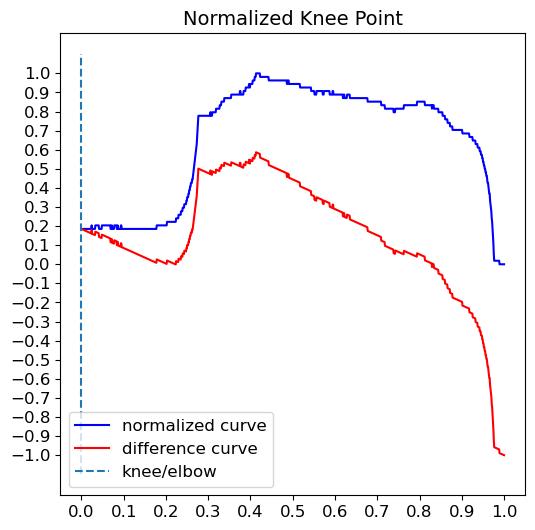

In [107]:
# Normalized data, normalized knee, and normalized distance curve.
kneedle.plot_knee_normalized()

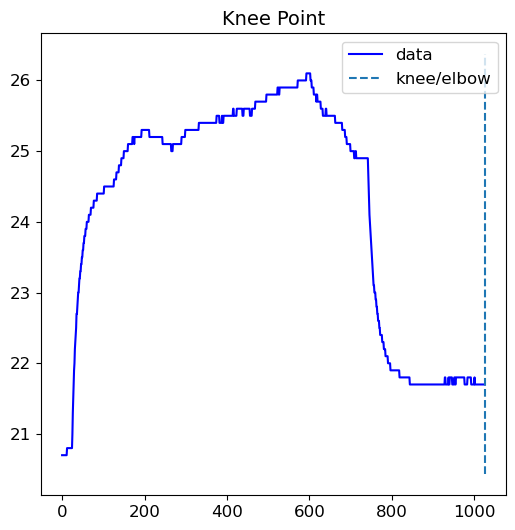

In [108]:
# Raw data and knee.
kneedle.plot_knee()

For some of the curve shapes `kneed` algorithm seems to fail and not find the obvious knee in the curve. Even with extended parameter tuning (e.g. activating polynomial interpolation with higher degrees set) one only gets close to the knee - but does never reach it ...

For such curve shapes, alternatives should be chosen, e.g. by finding **global maxima** or **minima**.

In [109]:
int_tolerance_window = 10

if ( (int_knee_point_theta_end <= df_clean.index[0] + int_tolerance_window) or
     (int_knee_point_theta_end >= df_clean.index[-1] - int_tolerance_window) ):
    print("I'm at the beginning or the end of the curve with index: {}".format(int_knee_point_theta_end))
    
    # get the last occurances of maximum values
    #col = 'T02_Klemme_Schliesser_E2'
    int_knee_point_theta_end = df_clean.loc[::-1, str_column].idxmax()
    print("Take last occurance of maximum value as new knee point: {}".format(int_knee_point_theta_end))
else:
    print("Everything's fine - I do nothing ...")

I'm at the beginning or the end of the curve with index: 1026
Take last occurance of maximum value as new knee point: 602


### Plotting the graph enriched with additional information

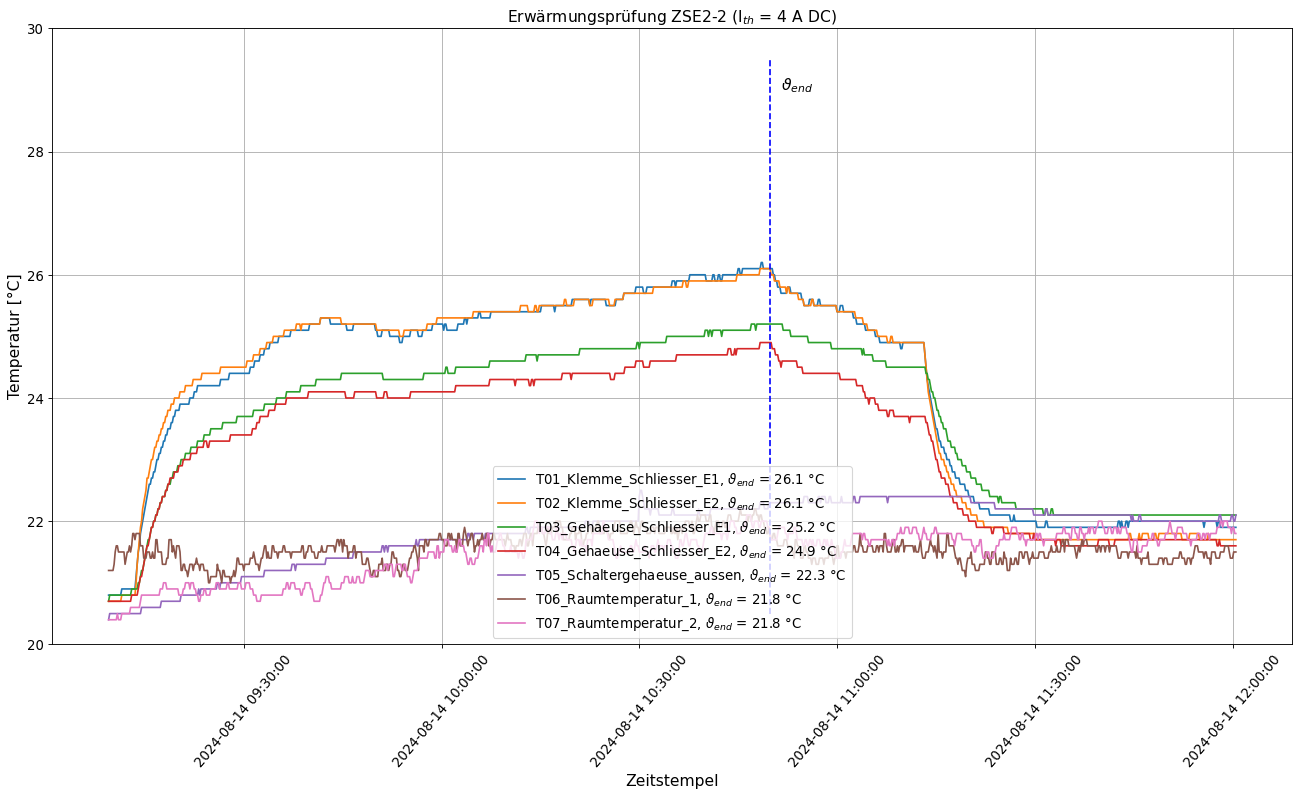

In [110]:
# figsize: a tuple (width, height) in inches
plt.figure(num=0, figsize=(20, 10), dpi=80, facecolor='w', edgecolor='k')
axes = plt.gca()

xfmt = mdates.DateFormatter('%Y-%m-%d %H:%M:%S')
axes.xaxis.set_major_formatter(xfmt)

# formula_sign = 'I$_{the}$' # with housing
formula_sign = 'I$_{th}$' # without housing

str_title = str_measurement_type + ' ' + str_measurement_specimen + ' (' + formula_sign + ' = ' + str_measurement_current + ')'
plt.title(str_title)

# iterate over all columns of the dataframe and create a plot line for each of them
for col in df_clean.columns:
    if (col != 'Datetime'):
        str_label = df_clean[col].name + r', $\vartheta_{end}$ = ' + str(df_clean.iloc[int_knee_point_theta_end][col]) + ' °C'
        
        plt.plot(df_clean['Datetime'], df_clean[col], '-', label=str_label)

plt.xlabel('Zeitstempel')
plt.ylabel('Temperatur [°C]')

if (str_measurement_current == '4 A DC'):
    # plt.ylim(20, 40)
    plt.ylim(20, 30)
elif (str_measurement_current == '6 A DC'):
    plt.ylim(20, 55)
elif (str_measurement_current == '10 A DC'):
    plt.ylim(20, 85)

plt.grid(True)

plt.setp(plt.gca().xaxis.get_majorticklabels(), 'rotation', 50)

# define location of legend
# supported values for 'loc': 
#   'best', 'upper right', 'upper left', 'lower left', 'lower right', 
#   'right', 'center left', 'center right', 'lower center', 'upper center', 'center'
plt.legend(loc="lower center")

# the x coords of this transformation are data, and the
# y coords are axes
ax = plt.gca()
trans = ax.get_xaxis_transform()

# draw a vertical cursor on the position of the knee (point of maximum curvature)
# it marks the end of the heating phase
plt.axvline(x = df_clean.iloc[int_knee_point_theta_end]['Datetime'], ymin = 0.05,
            ymax = 0.95, color = 'b', label = 'axvline - full height', linestyle='--')
plt.text(df_clean.iloc[int_knee_point_theta_end+10]['Datetime'], 0.9, r'$\vartheta_{end}$', transform=trans)

# save plot as PNG and PDF figure
# in order to obtain the same figure as shown in the notebook, the option 'bbox_inches = "tight"'
# has to be used - it basically extends or shrinks the bounding box such that all objects in the canvas are displayed
# found here: https://stackoverflow.com/a/45239920
str_image_file_path_png = './data_files/' + str_file_name_local.replace('.GTD', '.png')
str_image_file_path_pdf = './data_files/' + str_file_name_local.replace('.GTD', '.pdf')
plt.savefig(str_image_file_path_png, bbox_inches = 'tight')
plt.savefig(str_image_file_path_pdf, dpi=150, bbox_inches = 'tight')

plt.show()